## Answer 1: 

Celestial coordinates like Right Ascension (RA) and Declination (Dec) are usually fixed to a specific "Epoch" (a snapshot in time), typically **J2000.0**. (January 1, 2000). 

Due to Earth's **axial precession**, the orientation of the celestial coordinate
system slowly changes with time. As a result, the numerical values of RA and Dec
of a source change when expressed in a different epoch, the coordinate grid itself shifts slightly every year. While a distant source like Cygnus A doesn't physically move much (its proper motion is negligible for this purpose), its coordinates *relative to Earth's current equator* will change. To find the coordinates "today," we must transform the J2000 positions into the "Mean Equinox of Date" (often calculated using the FK5 reference frame for the specific observation time).

To demonstrate this effect:
1. Defined the J2000 coordinates of Cygnus A in the ICRS frame.
2. Then ransformed them to the current epoch using the FK5 frame.
3. Then computed the small shift in RA and Dec caused by precession.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import (
    SkyCoord, EarthLocation, AltAz,
    FK5, get_sun
)


In [2]:
# the fixed J2000 coordinates of cygnus A
cygnus_j2000 = SkyCoord(
    ra="19h59m28.3566s",
    dec="+40d44m02.096s",
    frame="icrs"
)

# current time
now = Time.now()

# J2000 coordinates to the current epoch (JNow)
cygnus_now = cygnus_j2000.transform_to(FK5(equinox=now))

print(f"Current time: {now.iso}")
print(f"J2000 RA/Dec : {cygnus_j2000.to_string('hmsdms')}")
print(f"JNow  RA/Dec : {cygnus_now.to_string('hmsdms')}")

# the shift due to precession
dra = (cygnus_now.ra - cygnus_j2000.ra).to(u.arcsec).value
ddec = (cygnus_now.dec - cygnus_j2000.dec).to(u.arcsec).value

print(f"Precession shift: ΔRA = {dra:.2f}\" , ΔDec = {ddec:.2f}\"")


Current time: 2026-01-18 14:12:07.873
J2000 RA/Dec : 19h59m28.3566s +40d44m02.096s
JNow  RA/Dec : 20h00m22.46393142s +40d48m22.98555438s
Precession shift: ΔRA = 811.61" , ΔDec = 260.89"


## Answer 2: Azimuth and Elevation from IIT Kanpur

To determine how Cygnus A appears in the sky to a ground-based observer,
converted its equatorial coordinates (RA, Dec) to horizontal coordinates:

- **Azimuth**: direction along the horizon
- **Elevation (Altitude)**: angle above the horizon

This conversion depends on:
- Observer's geographic location
- Time of observation

the azimuth and elevation of Cygnus A as observed from
**IIT Kanpur** at the current time:


In [3]:
# location = iitk
iitk_loc = EarthLocation(
    lat=26.5123 * u.deg,
    lon=80.2329 * u.deg,
    height=130 * u.m
)

# AltAz frame for the current time and location
local_frame = AltAz(obstime=now, location=iitk_loc)

# cygnus A coordinates to AltAz
cygnus_local = cygnus_j2000.transform_to(local_frame)

print(f"Azimuth  : {cygnus_local.az.deg:.4f} degrees")
print(f"Elevation: {cygnus_local.alt.deg:.4f} degrees")

if cygnus_local.alt.deg > 0:
    print("source is Above the horizon.")
else:
    print("source is Below the horizon.")


Azimuth  : 315.0421 degrees
Elevation: 2.6917 degrees
source is Above the horizon.


## Answer 3: polar sky plot of cygnus A

cygnus A movement across the sky over a period of 24 hours
as seen from IIT Kanpur.

In a true sky polar plot:
- Polar angle → **Azimuth**
- Radial distance → **Zenith distance = 90° − Elevation**

- The zenith at the center
- The horizon at the outer edge


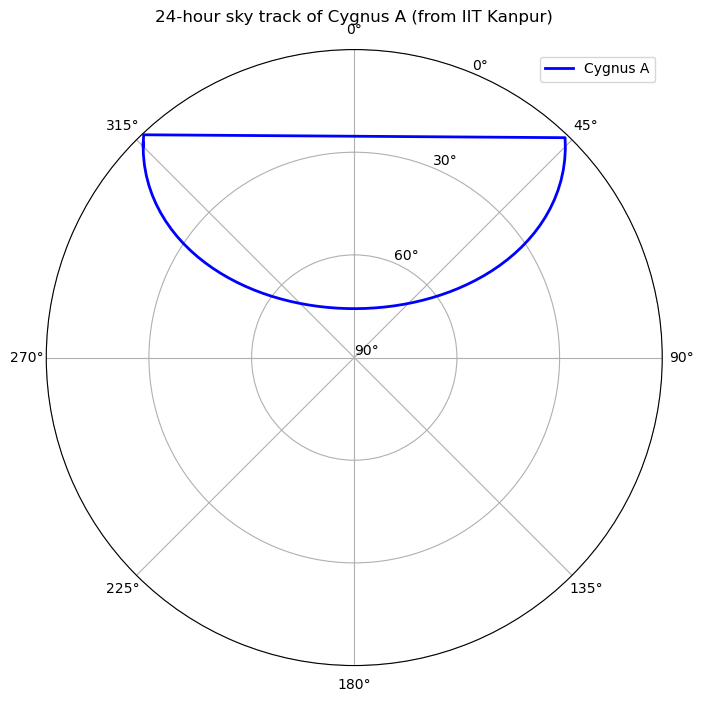

In [4]:
# times over the next 24 hours
time_steps = np.linspace(0, 24, 100) * u.hour
times_24h = now + time_steps

# AltAz frame for all times
frame_24h = AltAz(obstime=times_24h, location=iitk_loc)

# Cygnus A to AltAz over 24 hours
cygnus_track = cygnus_j2000.transform_to(frame_24h)

az_rad = cygnus_track.az.to(u.rad).value
alt_deg = cygnus_track.alt.deg

# altitude to zenith distance
r = 90 - alt_deg

# when source is above horizon
visible = alt_deg >= 0

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="polar")
ax.plot(az_rad[visible], r[visible], color="blue", lw=2, label="Cygnus A")

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_yticks([0, 30, 60, 90])
ax.set_yticklabels(["90°", "60°", "30°", "0°"])

ax.set_title("24-hour sky track of Cygnus A (from IIT Kanpur)", pad=20)
ax.legend()
plt.show()


## Answer 4: sun vs cygnus A – RA and Dec over one year

The apparent position of the Sun changes significantly over a year due to
earth’s orbital motion.

cygnus A, being an extragalactic radio source, has essentially fixed
coordinates on human timescales.

comparing:
- sun RA and Dec over one year
- cygnus A’s (approximately constant) RA and Dec over the same period


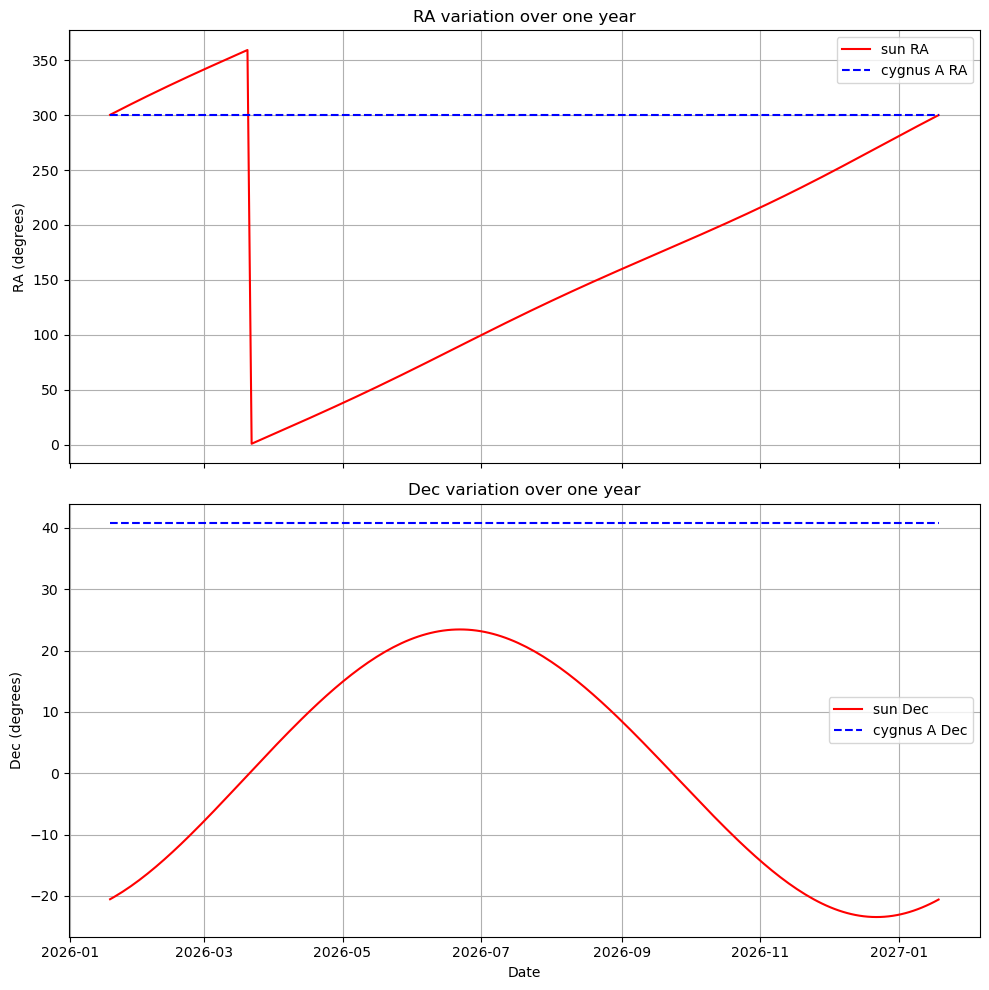

In [5]:
# time array covering one year
times_year = now + np.linspace(0, 365, 200) * u.day

# sun coordinates over the year
sun_coords = get_sun(times_year)

# Cygnus A coordinates (keeping it constant for comparison)
cygnus_ra = np.full(len(times_year), cygnus_j2000.ra.deg)
cygnus_dec = np.full(len(times_year), cygnus_j2000.dec.deg)

# RA comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax1.plot(times_year.datetime, sun_coords.ra.deg, label="sun RA", color="red")
ax1.plot(times_year.datetime, cygnus_ra, "--", label="cygnus A RA", color="blue")
ax1.set_ylabel("RA (degrees)")
ax1.set_title("RA variation over one year")
ax1.legend()
ax1.grid(True)

# Dec comparison
ax2.plot(times_year.datetime, sun_coords.dec.deg, label="sun Dec", color="red")
ax2.plot(times_year.datetime, cygnus_dec, "--", label="cygnus A Dec", color="blue")
ax2.set_ylabel("Dec (degrees)")
ax2.set_xlabel("Date")
ax2.set_title("Dec variation over one year")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### References

1.  Astropy : https://docs.astropy.org/en/stable/index_user_docs.html

2. Astro-colibry : https://astro-colibri.com/
